In [32]:

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             confusion_matrix, classification_report, mean_squared_error, roc_curve)
from sklearn.decomposition import PCA

In [33]:
CSV_PATH = 'Churn_Modelling.csv'
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
# ---------- Load dataset ----------

print('Loading dataset from', CSV_PATH)
df = pd.read_csv(CSV_PATH)
print('Dataset shape:', df.shape)

df['Gender'] = df['Gender'].map({'Male':0,'Female':1})
df['Geography'] = df['Geography'].map({'France':1,'Germany':2,'Spain':3})

ignore_cols = ['RowNumber','CustomerId','Surname','Exited']
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in ignore_cols]


Loading dataset from Churn_Modelling.csv
Dataset shape: (10000, 14)


In [52]:
print(df.head())
print(df.dtypes)
print(df.describe().T)
print(df.shape)
print(df.isnull().sum())
print(df.duplicated().sum())


   RowNumber  CustomerId   Surname  CreditScore  Geography  Gender  Age  \
0          1    15634602  Hargrave          619          1       1   42   
1          2    15647311      Hill          608          3       1   41   
2          3    15619304      Onio          502          1       1   42   
3          4    15701354      Boni          699          1       1   39   
4          5    15737888  Mitchell          850          3       1   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00            1.0          1               1   
1       1   83807.86            1.0          0               1   
2       8  159660.80            3.0          1               0   
3       1       0.00            2.0          0               0   
4       2  125510.82            1.0          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4      

In [35]:
num_cols = df.select_dtypes(include=["int64","float64"]).columns.tolist()
if TARGET_COL in num_cols:
    num_cols.remove(TARGET_COL)
cat_cols = df.select_dtypes(include=["object","category"]).columns.tolist()

print("\nNumeric columns:", num_cols)
print("Categorical columns:", cat_cols)


Numeric columns: ['RowNumber', 'CustomerId', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
Categorical columns: ['Surname']


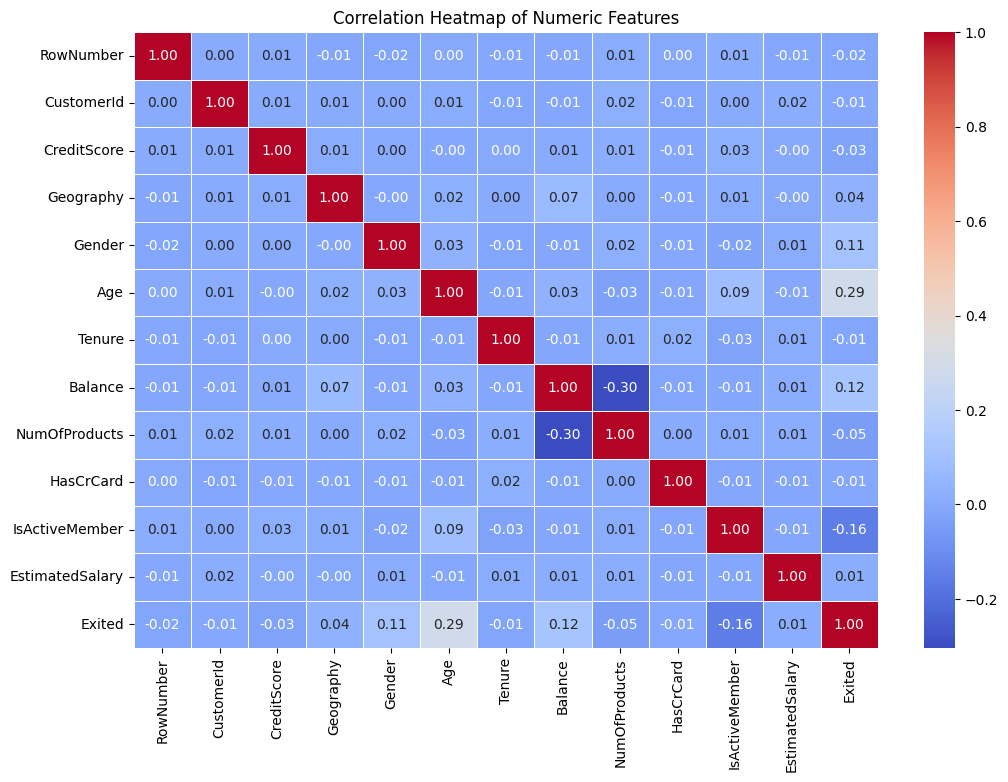

In [36]:
# 📊 Correlation Heatmap Visualization
plt.figure(figsize=(12, 8))
corr = df.corr(numeric_only=True)

# Generate heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()


In [37]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

print("\nSkewness before Transformation:")
for col in numeric_cols:
    skew_val = df[col].skew()
    print(f"{col}: {skew_val:.2f}")




Skewness before Transformation:
RowNumber: 0.00
CustomerId: 0.00
CreditScore: -0.07
Geography: 0.50
Gender: 0.18
Age: 1.01
Tenure: 0.01
Balance: -0.14
NumOfProducts: 0.75
HasCrCard: -0.90
IsActiveMember: -0.06
EstimatedSalary: 0.00
Exited: 1.47


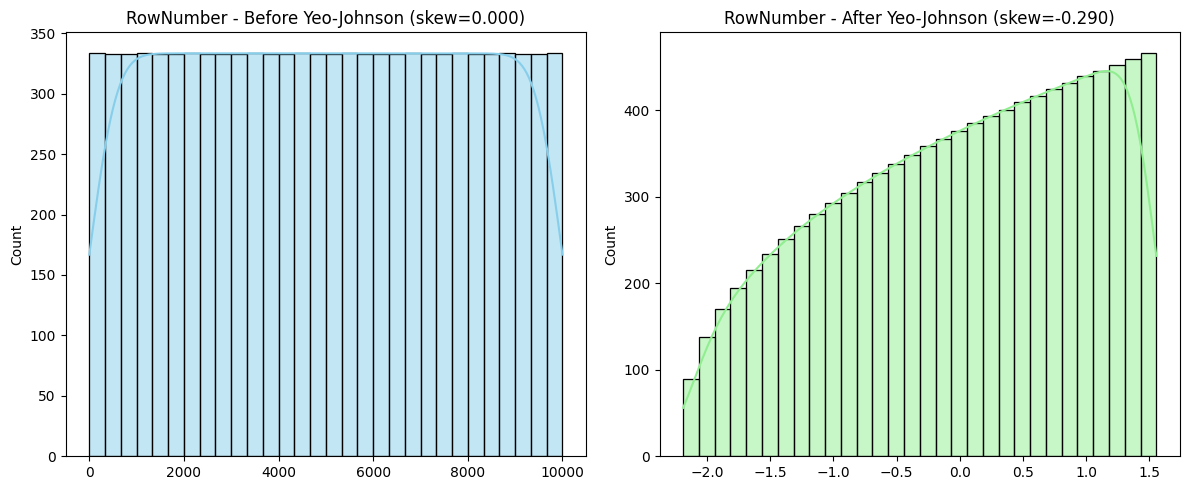

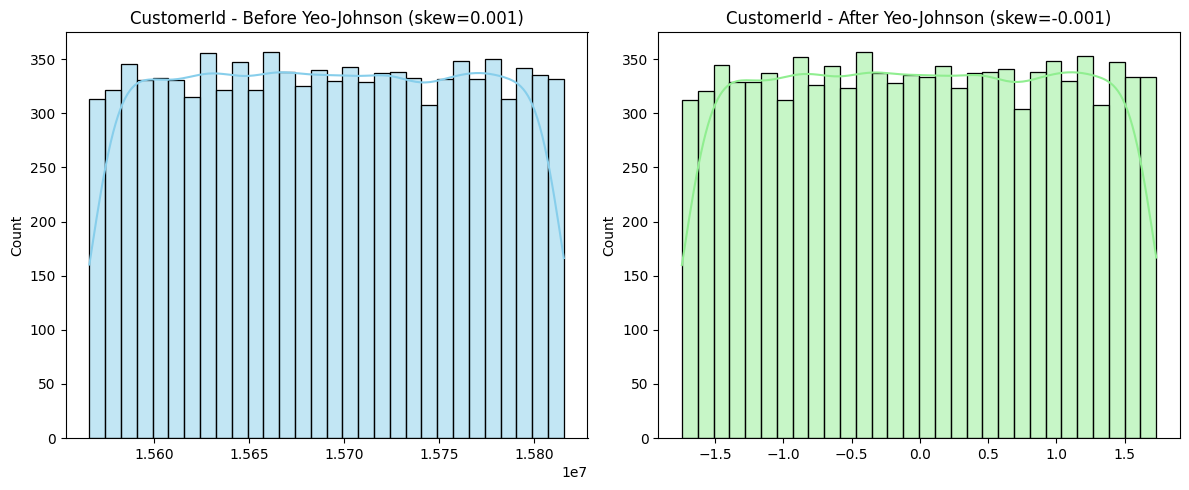

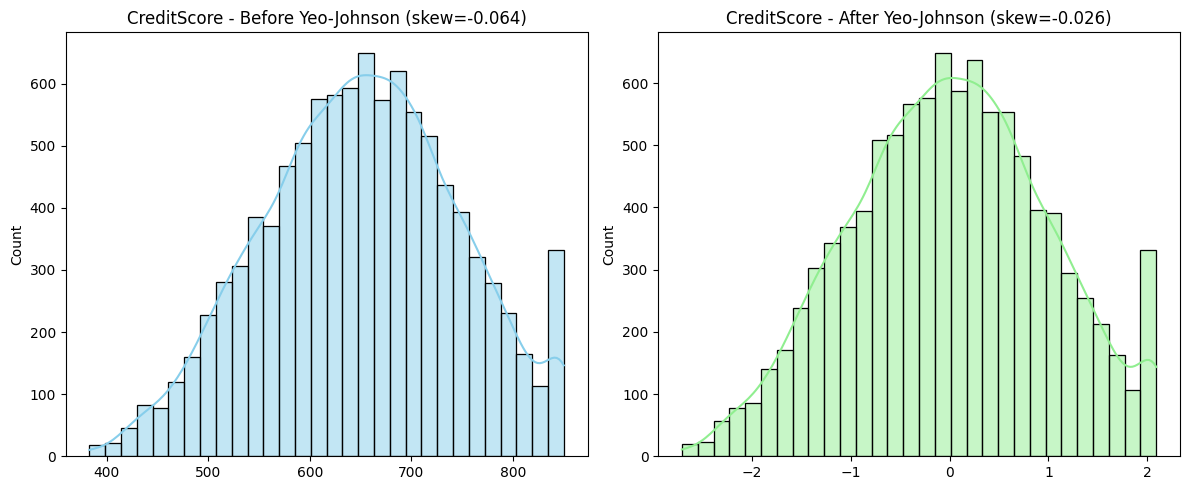

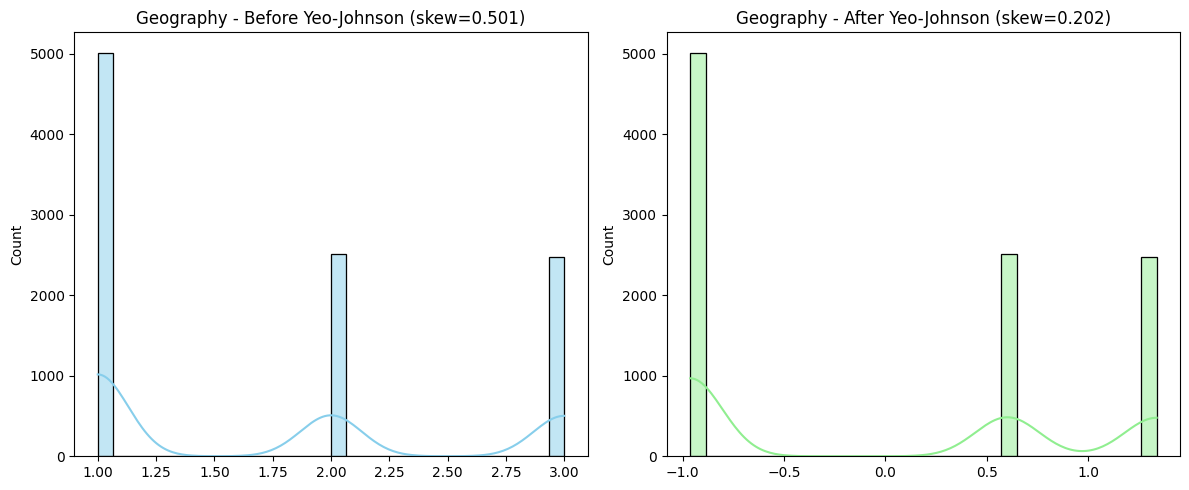

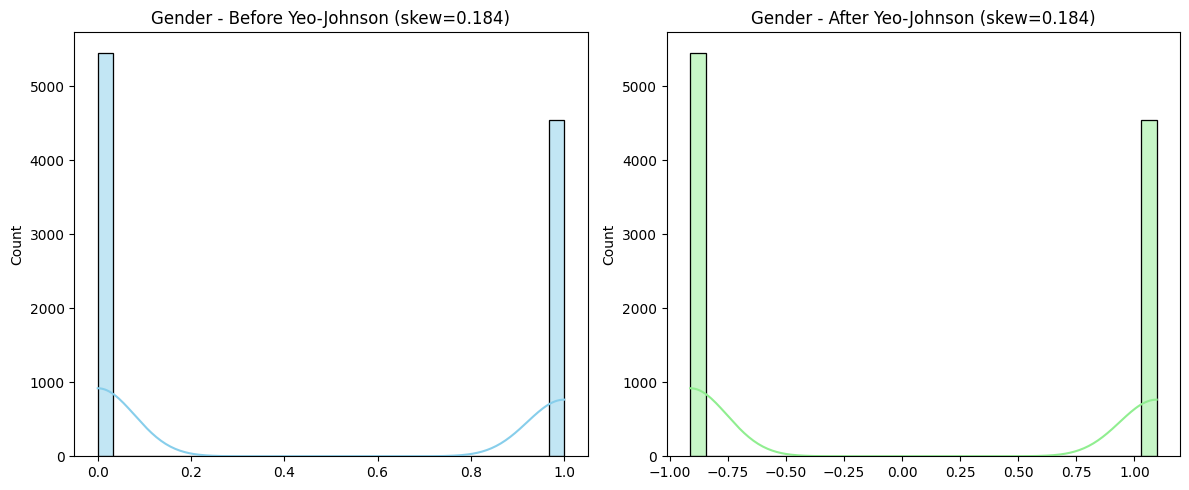

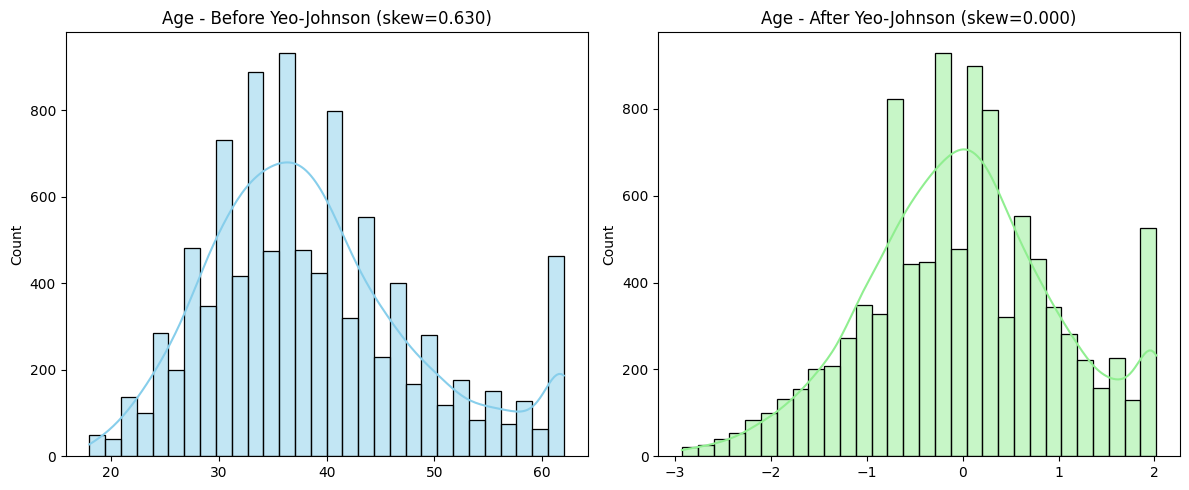

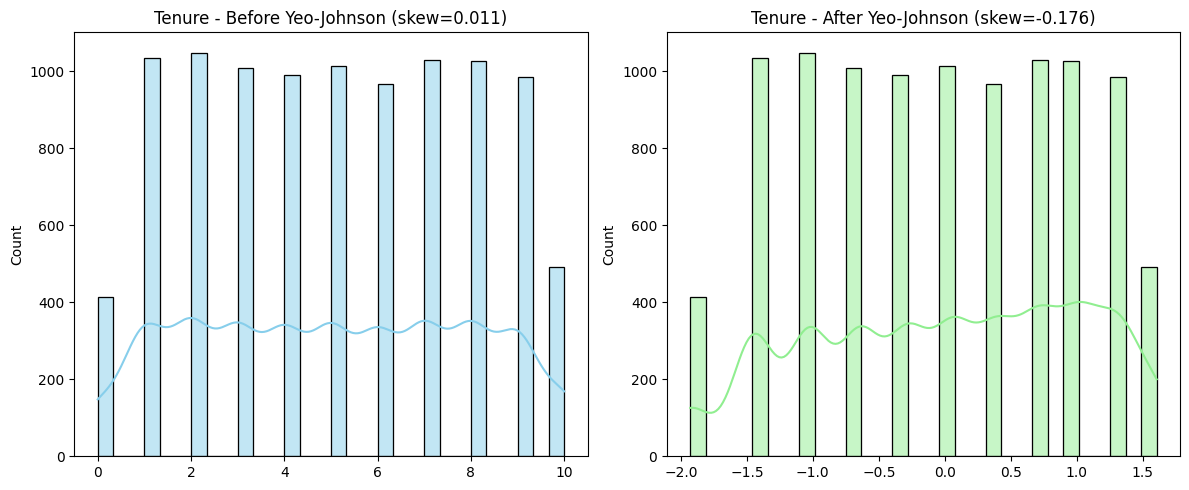

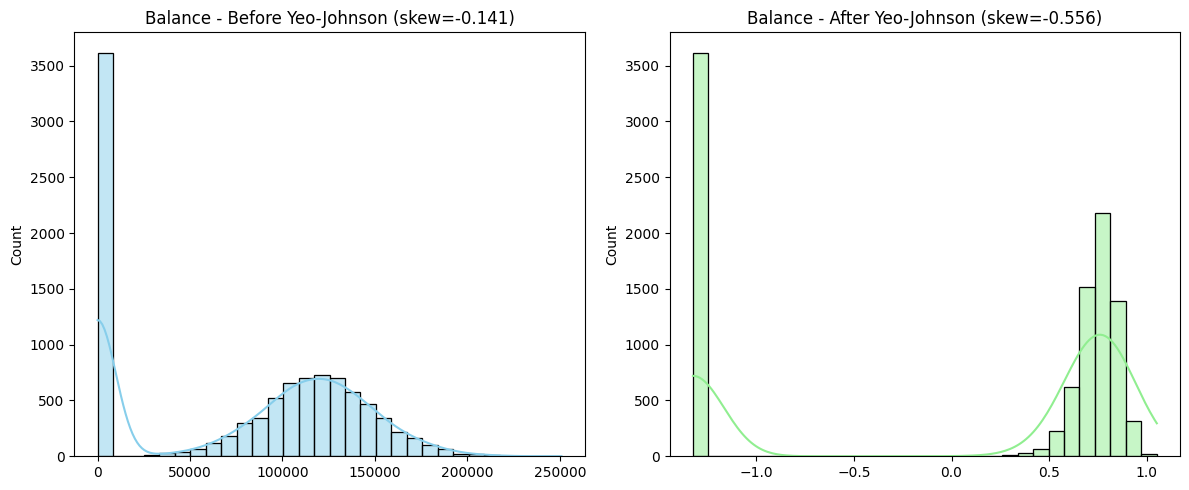

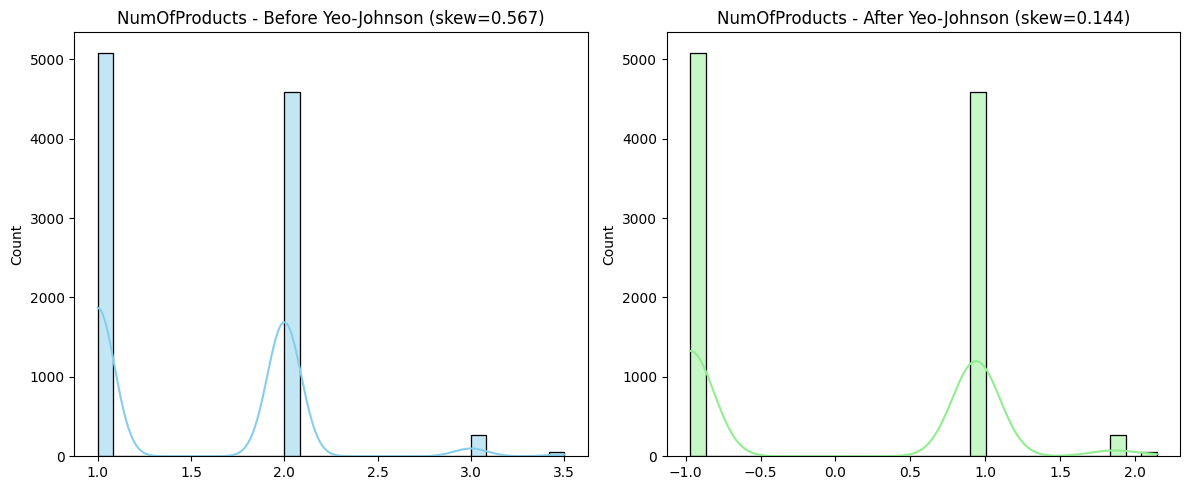

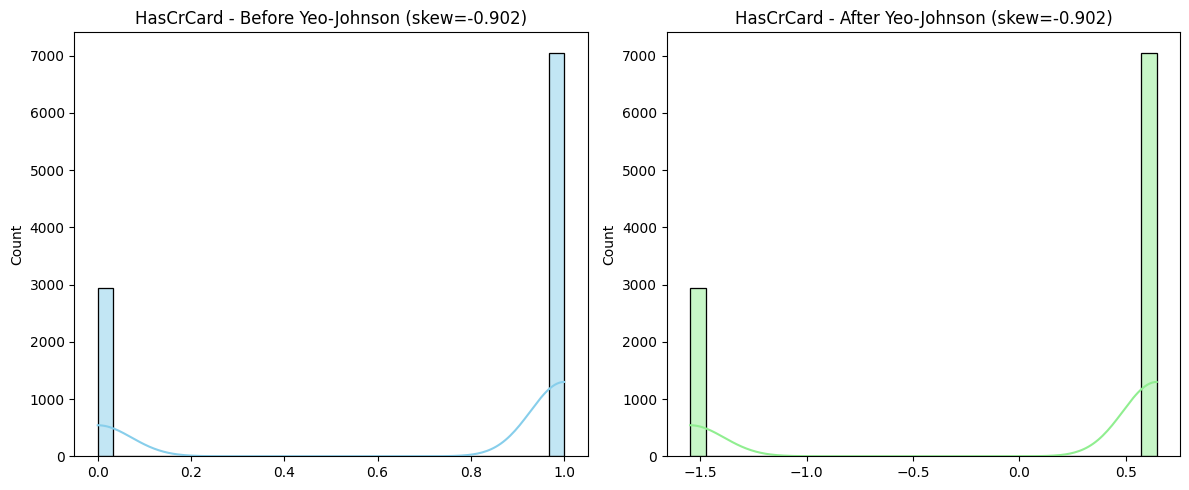

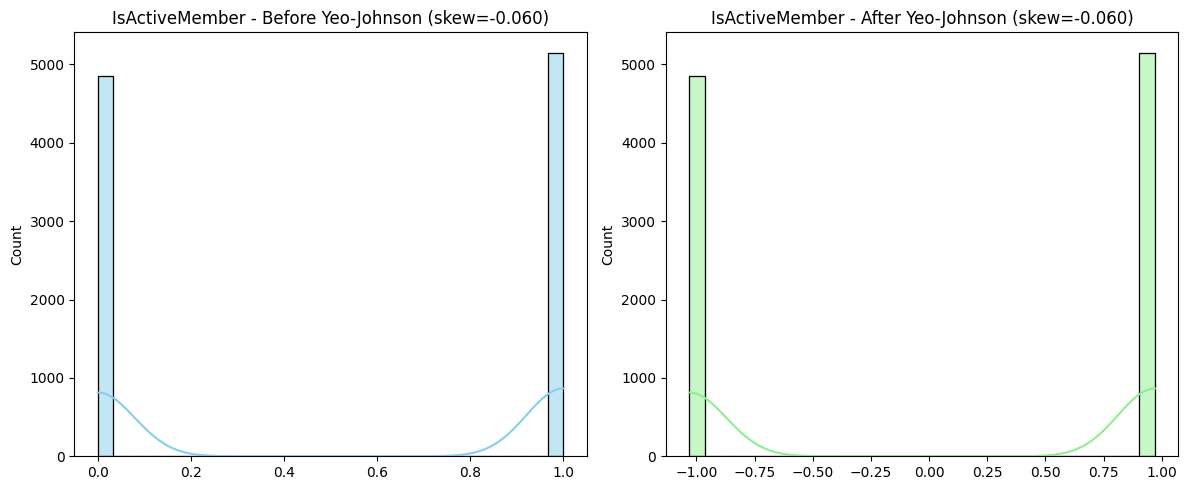

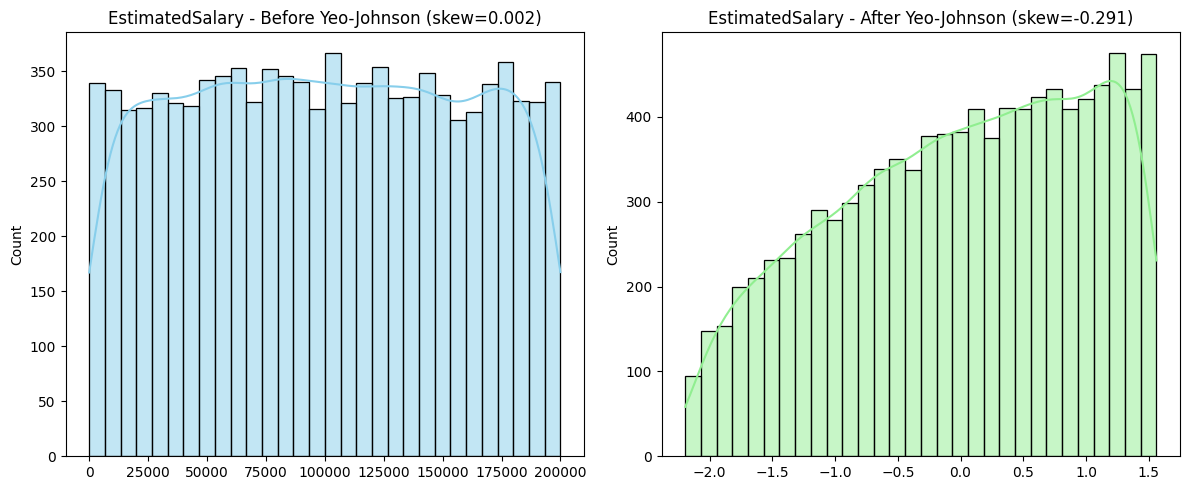

In [54]:
transformer = PowerTransformer(method='yeo-johnson')

for col in num_cols:
    arr = df[col].values.reshape(-1,1)
    skew_before = pd.Series(arr.ravel()).skew()
    transformed = transformer.fit_transform(arr).ravel()
    skew_after = pd.Series(transformed).skew()

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    sns.histplot(arr.ravel(), kde=True, color='skyblue', bins=30)
    plt.title(f'{col} - Before Yeo-Johnson (skew={skew_before:.3f})')

    plt.subplot(1,2,2)
    sns.histplot(transformed, kde=True, color='lightgreen', bins=30)
    plt.title(f'{col} - After Yeo-Johnson (skew={skew_after:.3f})')

    plt.tight_layout()
    plt.show()

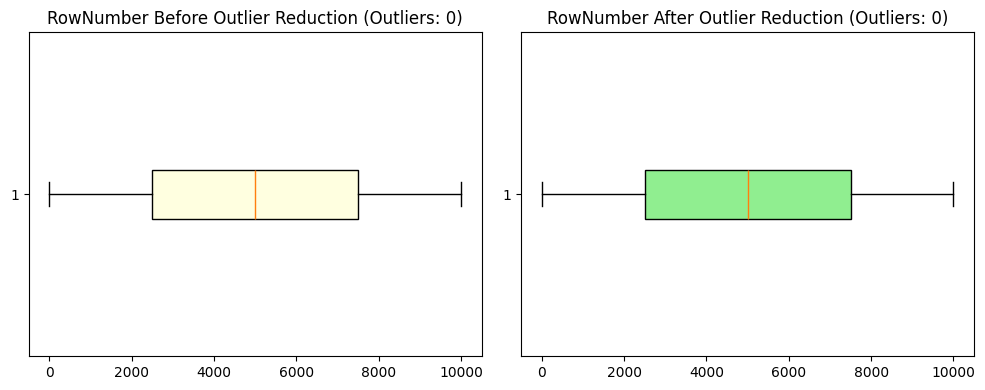

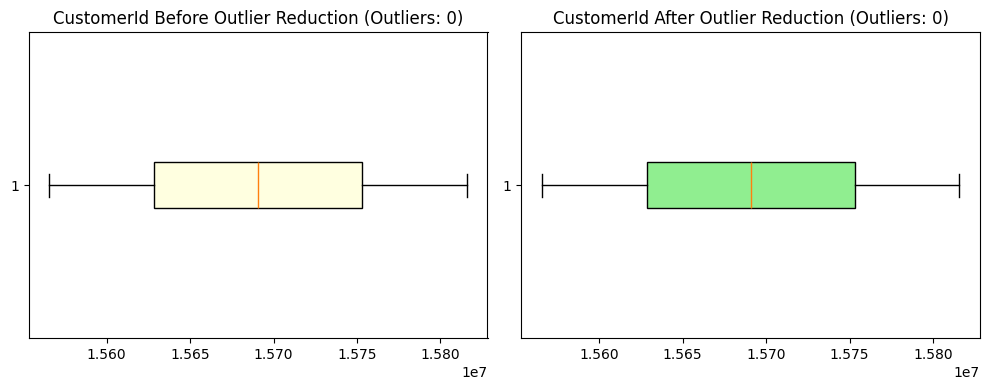

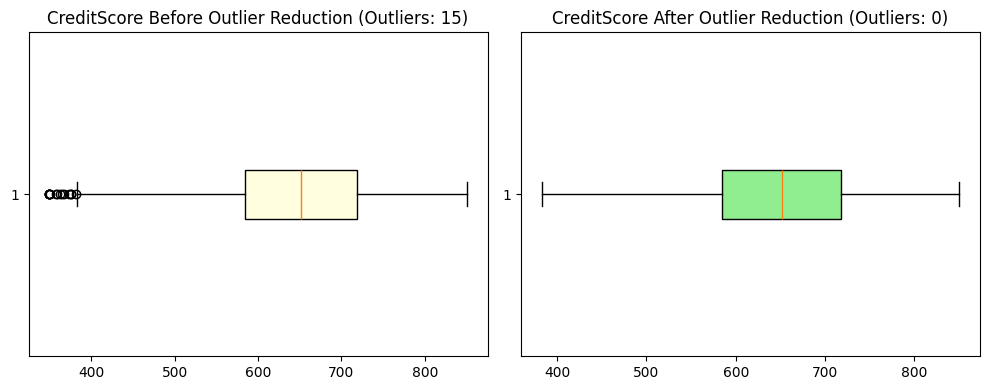

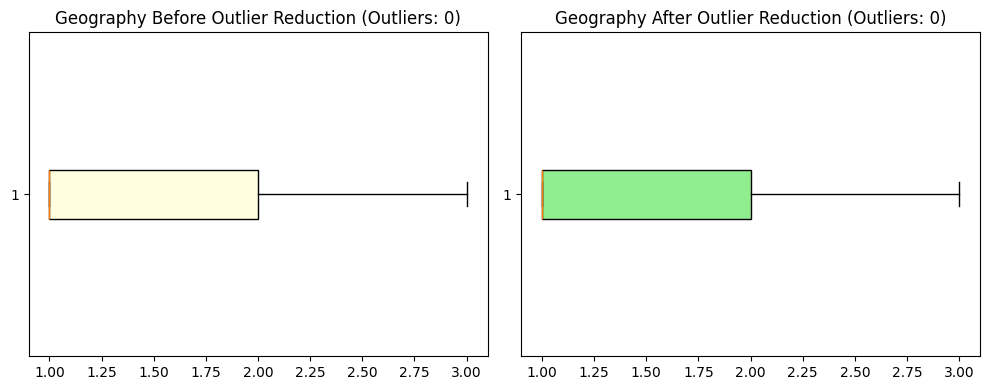

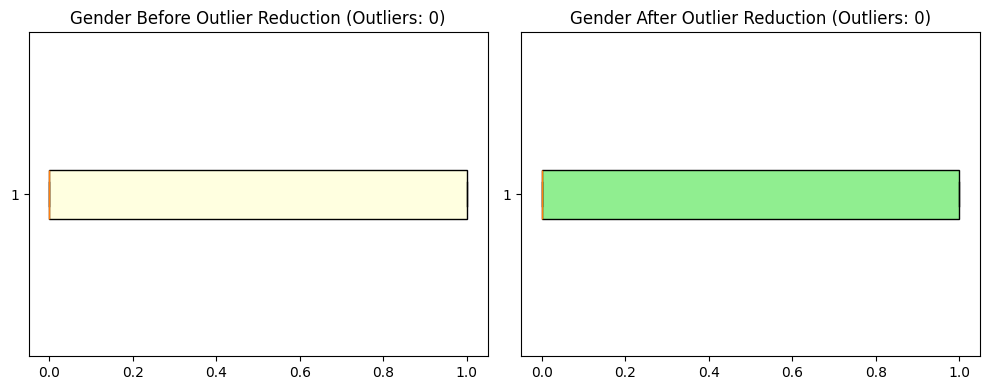

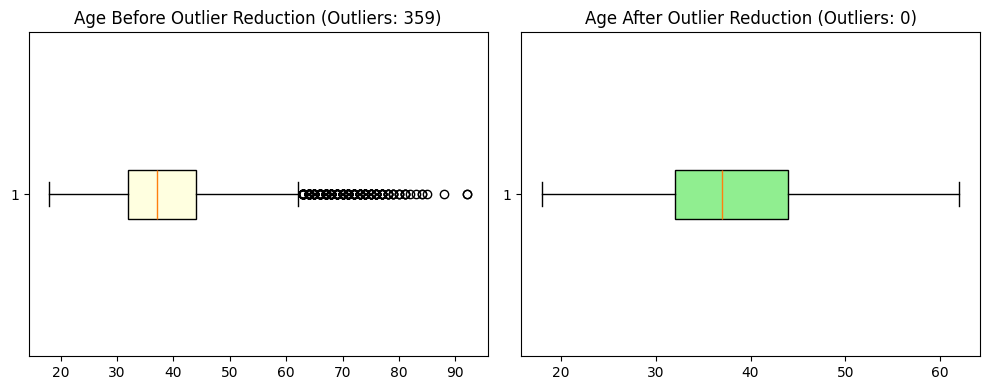

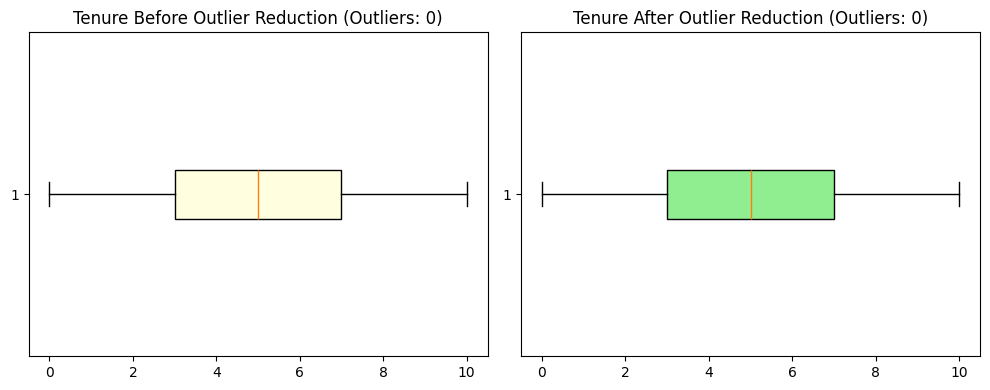

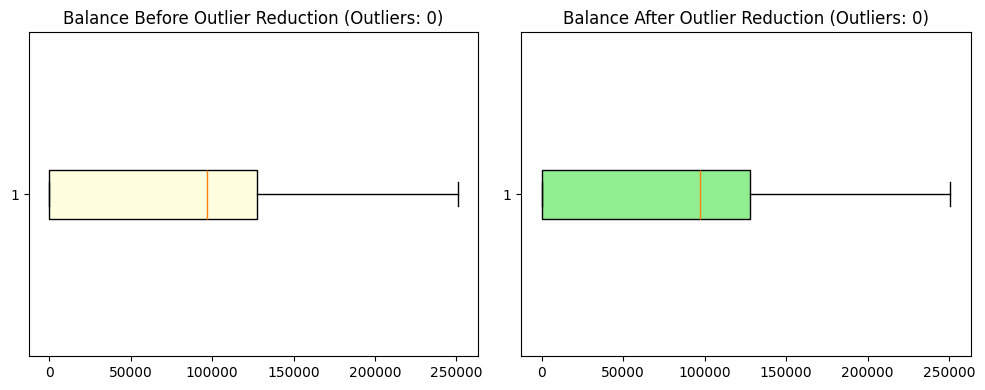

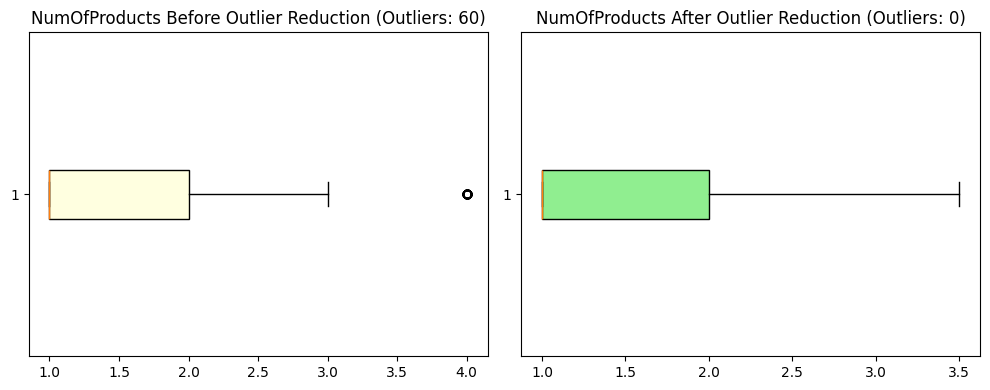

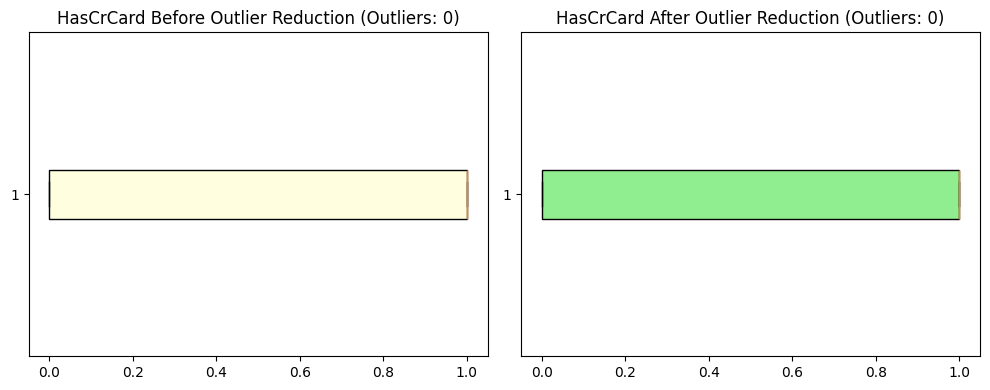

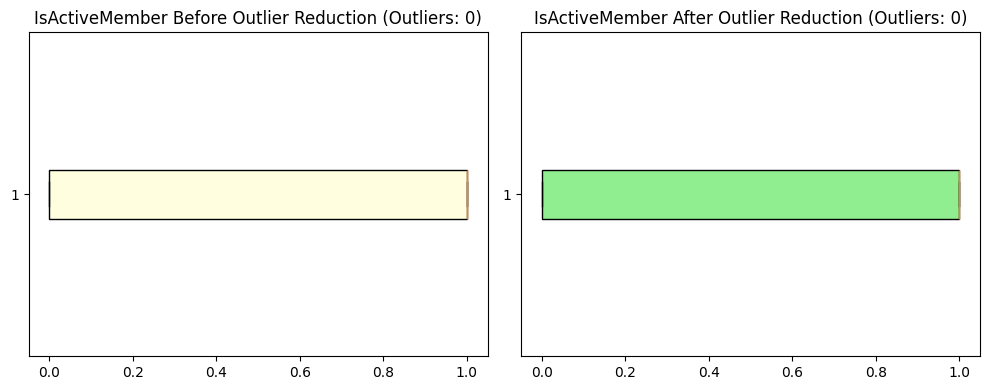

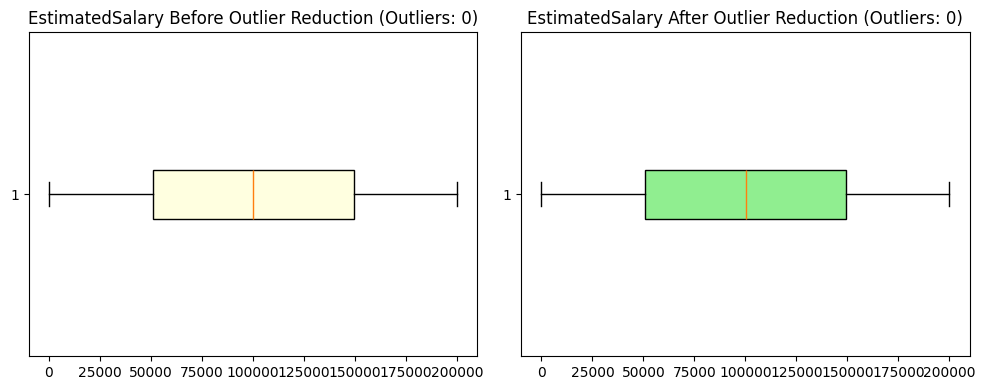


Outlier counts before reduction:
RowNumber: 0
CustomerId: 0
CreditScore: 15
Geography: 0
Gender: 0
Age: 359
Tenure: 0
Balance: 0
NumOfProducts: 60
HasCrCard: 0
IsActiveMember: 0
EstimatedSalary: 0

Outlier counts after reduction:
RowNumber: 0
CustomerId: 0
CreditScore: 0
Geography: 0
Gender: 0
Age: 0
Tenure: 0
Balance: 0
NumOfProducts: 0
HasCrCard: 0
IsActiveMember: 0
EstimatedSalary: 0


In [42]:
outlier_counts_before = {}
outlier_counts_after = {}
for col in num_cols:
    series = df[col]
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    low = Q1 - 1.5*IQR
    high = Q3 + 1.5*IQR

    outliers = series[(series<low)|(series>high)]
    outlier_counts_before[col] = outliers.shape[0]

    series_capped = series.copy()
    series_capped[series_capped<low] = low
    series_capped[series_capped>high] = high
    outlier_counts_after[col] = ((series_capped<low)|(series_capped>high)).sum()
    df[col] = series_capped

    # Side-by-side boxplots
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.boxplot(series, vert=False, patch_artist=True, boxprops=dict(facecolor='lightyellow'))
    plt.title(f'{col} Before Outlier Reduction (Outliers: {outlier_counts_before[col]})')

    plt.subplot(1,2,2)
    plt.boxplot(series_capped, vert=False, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
    plt.title(f'{col} After Outlier Reduction (Outliers: {outlier_counts_after[col]})')
    plt.tight_layout()
    plt.show()

print('\nOutlier counts before reduction:')
for k,v in outlier_counts_before.items():
    print(f'{k}: {v}')

print('\nOutlier counts after reduction:')
for k,v in outlier_counts_after.items():
    print(f'{k}: {v}')


In [43]:
df_model = df.drop(columns=['RowNumber','CustomerId','Surname'])
y = df_model['Exited']
X = df_model.drop(columns=['Exited'])
X = X.fillna(X.median())
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0     0.8267    0.9730    0.8939      1593
           1     0.6560    0.2015    0.3083       407

    accuracy                         0.8160      2000
   macro avg     0.7413    0.5872    0.6011      2000
weighted avg     0.7919    0.8160    0.7747      2000



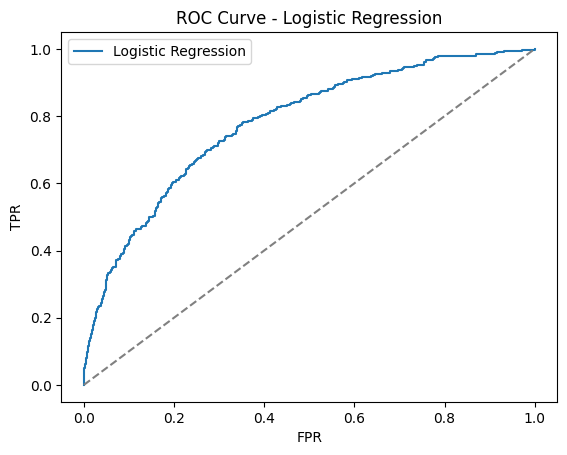

In [45]:
logreg = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)
y_prob_lr = logreg.predict_proba(X_test)[:,1]

print('\nLogistic Regression Classification Report:')
print(classification_report(y_test, y_pred_lr, digits=4))

fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()

In [46]:
param_grid = {'max_depth':[2,5,None],'min_samples_split':[2,5,10,20]}
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
gs = GridSearchCV(dt, param_grid, cv=5, scoring='f1')
gs.fit(X_train, y_train)
dt_best = gs.best_estimator_

y_pred_dt = dt_best.predict(X_test)
y_prob_dt = dt_best.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, y_pred_dt)
prec = precision_score(y_test, y_pred_dt)
rec = recall_score(y_test, y_pred_dt)
f1 = f1_score(y_test, y_pred_dt)
roc = roc_auc_score(y_test, y_prob_dt)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_dt))

print('\nDecision Tree Metrics:')
print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, ROC-AUC: {roc:.4f}, RMSE: {rmse:.4f}')
print('\nConfusion Matrix:\n', confusion_matrix(y_test, y_pred_dt))



Decision Tree Metrics:
Accuracy: 0.8190, Precision: 0.5616, Recall: 0.5037, F1: 0.5311, ROC-AUC: 0.7566, RMSE: 0.4254

Confusion Matrix:
 [[1433  160]
 [ 202  205]]


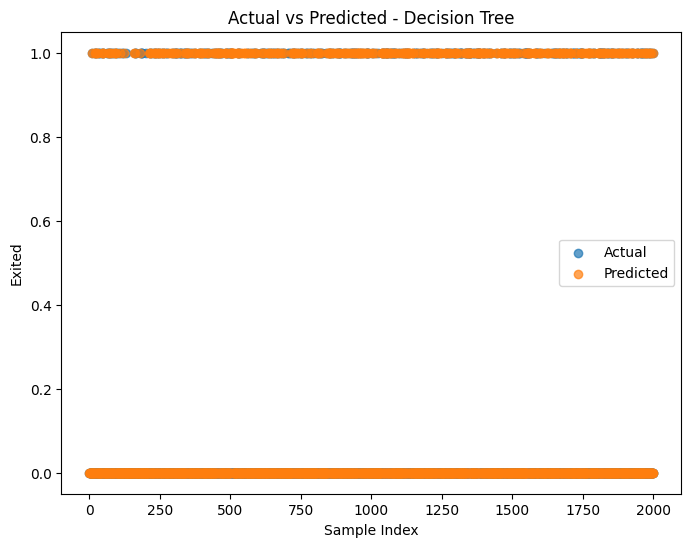

In [47]:
plt.figure(figsize=(8,6))
plt.scatter(range(len(y_test)), y_test, label='Actual', alpha=0.7)
plt.scatter(range(len(y_test)), y_pred_dt, label='Predicted', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Exited')
plt.title('Actual vs Predicted - Decision Tree')
plt.legend()
plt.show()

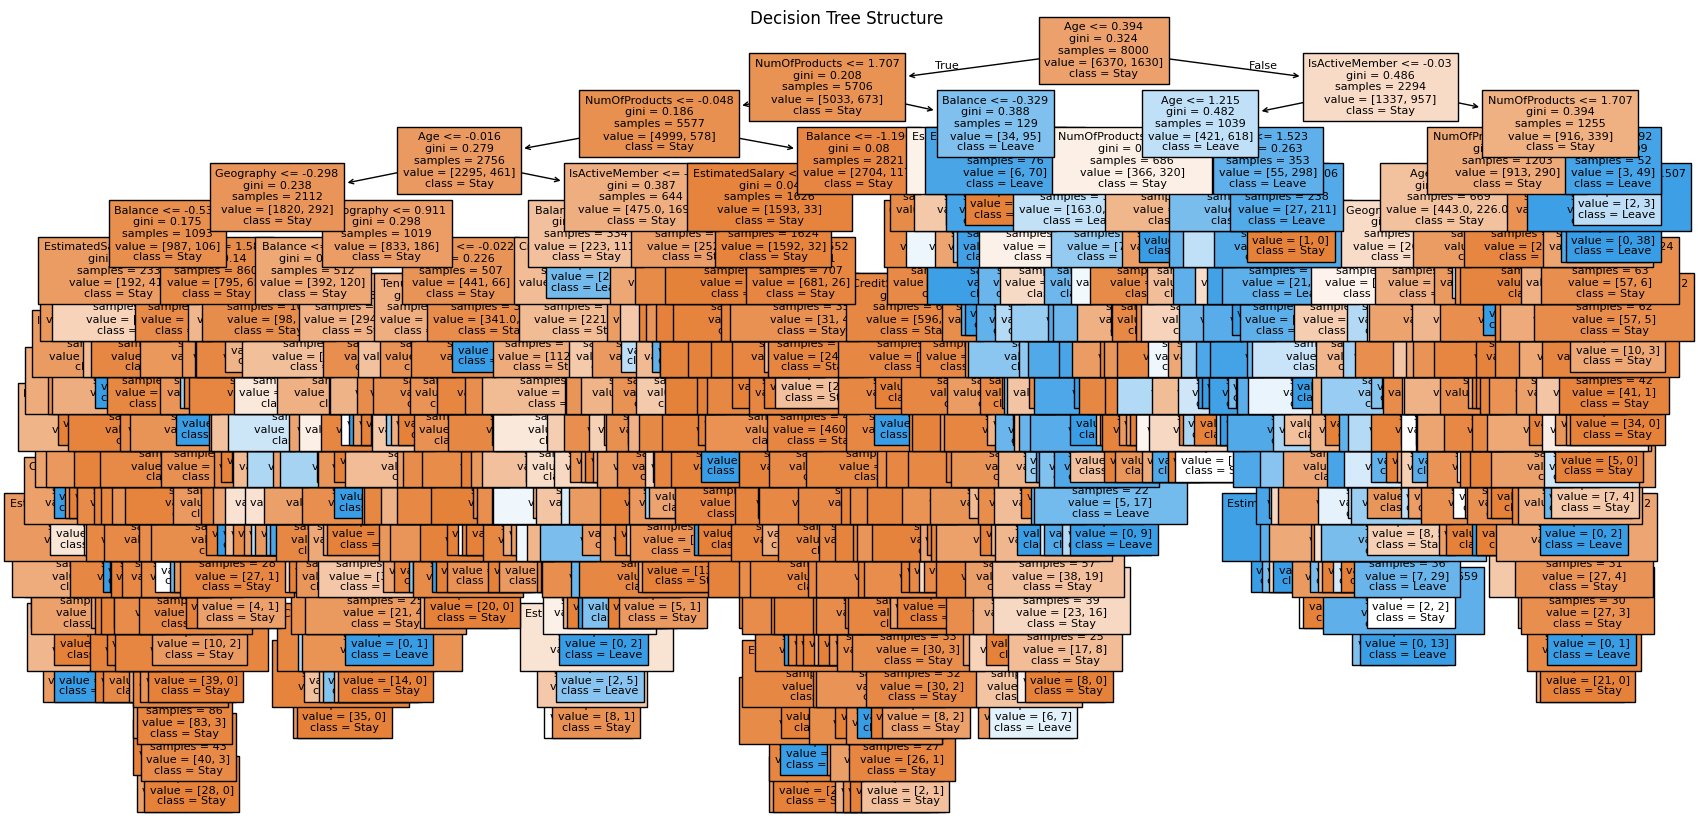

In [48]:
plt.figure(figsize=(20,10))
plot_tree(dt_best, feature_names=X.columns, class_names=['Stay','Leave'], filled=True, fontsize=8)
plt.title('Decision Tree Structure')
plt.show()

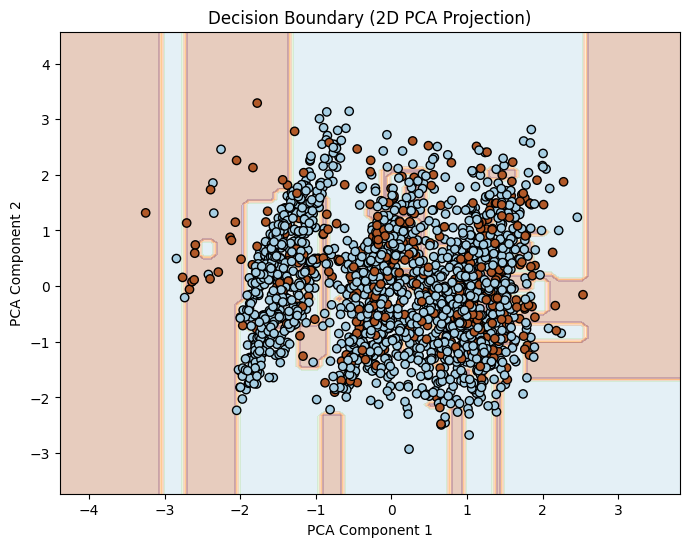


EDA, model training, and visualization complete.


In [49]:
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)
X_test_2d = pca.transform(X_test)

dt_2d = DecisionTreeClassifier(max_depth=dt_best.max_depth, min_samples_split=dt_best.min_samples_split, random_state=RANDOM_STATE)
dt_2d.fit(X_train_2d, y_train)

x_min, x_max = X_train_2d[:,0].min()-1, X_train_2d[:,0].max()+1
y_min, y_max = X_train_2d[:,1].min()-1, X_train_2d[:,1].max()+1
xx, yy = np.meshgrid(np.arange(x_min,x_max,0.1), np.arange(y_min,y_max,0.1))
Z = dt_2d.predict(np.c_[xx.ravel(),yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
plt.scatter(X_test_2d[:,0], X_test_2d[:,1], c=y_test, edgecolor='k', cmap=plt.cm.Paired)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Decision Boundary (2D PCA Projection)')
plt.show()

print('\nEDA, model training, and visualization complete.')
